# Electricity Demand Forecasting: LightGBM + TFT Ensemble

This notebook implements a 48-hour ahead electricity demand forecasting system using:
- **LightGBM** for feature-based forecasting
- **Temporal Fusion Transformer (TFT)** for sequence modeling
- **Ensemble approach** combining both models

**Evaluation**: MAPE on hours 25-48 (second day only) for period 2023-2025

## 1. Setup and Installation

In [ ]:
# Install required packages
!pip install lightgbm darts pandas numpy scikit-learn matplotlib seaborn
!pip install pytorch-forecasting pytorch-lightning torch
!pip install optuna  # for hyperparameter optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# LightGBM
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Darts for TFT
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# Set random seeds
np.random.seed(42)
pl.seed_everything(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

INFO:lightning_fabric.utilities.seed:Seed set to 42


## 2. Data Loading and Preparation

In [ ]:
# Upload your combined_dataset.csv file to Colab
from google.colab import files

print("Please upload your combined_dataset.csv file:")
uploaded = files.upload()

# Load the combined dataset
df = pd.read_csv('combined_dataset.csv', index_col=0, parse_dates=True)
print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Columns: {list(df.columns)}")

Please upload your combined_dataset.csv file:


Saving combined_dataset.csv to combined_dataset.csv
Dataset loaded: (350688, 24)
Date range: 2015-04-01 00:00:00 to 2025-03-31 23:45:00
Columns: ['unique_id', 'y', 'temperature', 'humidity', 'dew_point', 'rain', 'wind_speed', 'pressure', 'hour', 'day_of_week', 'day_of_month', 'day_of_year', 'month', 'quarter', 'year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'season', 'quarter_hour']


Training period: 2015-04-01 00:00:00 to 2023-03-31 23:45:00
Training samples: 280,512
Test period: 2023-04-01 00:00:00 to 2025-03-31 23:45:00
Test samples: 70,176


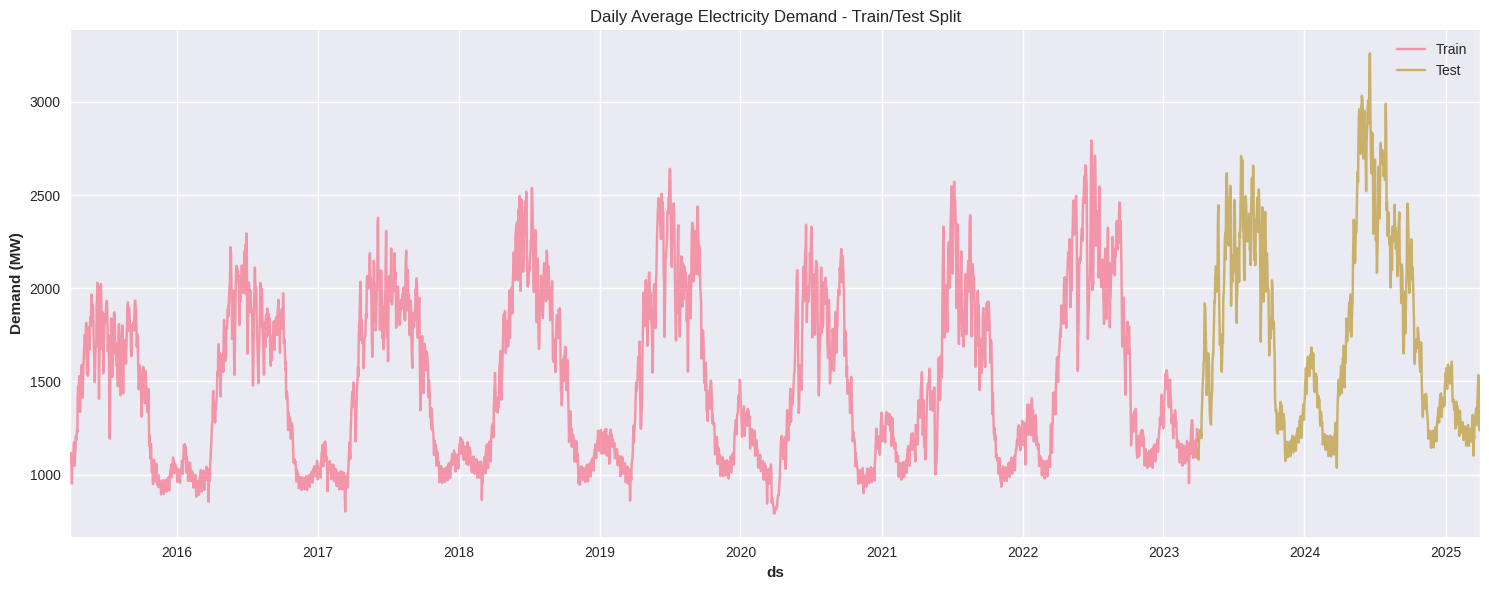

In [ ]:
# Define train/test splits
train_end = '2023-03-31 23:45:00'
test_start = '2023-04-01 00:00:00'
test_end = '2025-03-31 23:45:00'

# Split data
train_df = df[df.index <= train_end].copy()
test_df = df[(df.index >= test_start) & (df.index <= test_end)].copy()

print(f"Training period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Training samples: {len(train_df):,}")
print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")
print(f"Test samples: {len(test_df):,}")

# Visualize the split
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
train_df['y'].resample('D').mean().plot(ax=ax, label='Train', alpha=0.7)
test_df['y'].resample('D').mean().plot(ax=ax, label='Test', alpha=0.7)
ax.set_title('Daily Average Electricity Demand - Train/Test Split')
ax.set_ylabel('Demand (MW)')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Feature Engineering for LightGBM

In [ ]:
def create_lag_features(df, target_col='y', lags=[1, 2, 4, 24, 48, 96, 96*7]):
    """Create lag features for target variable"""
    df_features = df.copy()

    for lag in lags:
        df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)

    return df_features

def create_rolling_features(df, target_col='y', windows=[4, 24, 48, 96]):
    """Create rolling statistical features"""
    df_features = df.copy()

    for window in windows:
        # Rolling statistics
        rolling = df_features[target_col].rolling(window=window, min_periods=1)
        df_features[f'{target_col}_roll_mean_{window}'] = rolling.mean()
        df_features[f'{target_col}_roll_std_{window}'] = rolling.std()
        df_features[f'{target_col}_roll_min_{window}'] = rolling.min()
        df_features[f'{target_col}_roll_max_{window}'] = rolling.max()

    return df_features

def create_weather_interactions(df):
    """Create weather interaction features"""
    df_features = df.copy()

    # Temperature interactions
    if 'temperature' in df.columns and 'hour' in df.columns:
        df_features['temp_hour_interaction'] = df_features['temperature'] * df_features['hour']
        df_features['temp_squared'] = df_features['temperature'] ** 2

    # Humidity interactions
    if 'humidity' in df.columns and 'temperature' in df.columns:
        df_features['humid_temp_interaction'] = df_features['humidity'] * df_features['temperature']

    # Seasonal temperature
    if 'temperature' in df.columns and 'month' in df.columns:
        df_features['temp_seasonal'] = df_features['temperature'] * df_features['month_sin']

    return df_features

def prepare_data_for_lightgbm(df, target_col='y'):
    """Prepare data for LightGBM by handling categorical variables and data types"""
    df_clean = df.copy()

    # Handle categorical columns
    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    print(f"Found categorical columns: {list(categorical_columns)}")

    for col in categorical_columns:
        if col != target_col:
            if col == 'season':
                # Label encode seasons
                season_mapping = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
                df_clean[col] = df_clean[col].map(season_mapping).fillna(0)
            elif col == 'unique_id':
                # Drop unique_id column (not useful for forecasting)
                df_clean = df_clean.drop(columns=[col])
            else:
                # Generic label encoding
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df_clean[col] = le.fit_transform(df_clean[col].astype(str))

    # Ensure all columns are numeric
    for col in df_clean.columns:
        if col != target_col:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Fill any remaining NaN values
    df_clean = df_clean.fillna(0)

    print(f"Data prepared for LightGBM: {df_clean.shape}")
    print(f"Data types: {df_clean.dtypes.value_counts()}")

    return df_clean

# Apply feature engineering and prepare for LightGBM
print("Creating features for training data...")
train_features = create_lag_features(train_df)
train_features = create_rolling_features(train_features)
train_features = create_weather_interactions(train_features)

# Prepare data for LightGBM (handle categorical variables)
train_features = prepare_data_for_lightgbm(train_features)

print(f"Training features shape: {train_features.shape}")
print(f"Feature columns: {train_features.shape[1] - 1}")  # -1 for target column

Creating features for training data...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280512, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64
Training features shape: (280512, 50)
Feature columns: 49


## 4. LightGBM Model Implementation

In [ ]:
class LightGBMForecaster:
    def __init__(self, forecast_horizon=192):
      self.forecast_horizon = forecast_horizon
      self.models = {}
      self.feature_cols = None
      self.best_params = None  # NEW: Store optimized parameters

    def prepare_features(self, df, target_col='y'):
        """Prepare features for training"""
        # Get all columns except target
        feature_cols = [col for col in df.columns if col != target_col]

        # Remove rows with NaN values (due to lag features)
        df_clean = df.dropna()

        X = df_clean[feature_cols]
        y = df_clean[target_col]

        return X, y, feature_cols

    def train_direct_forecasting(self, train_df, target_col='y'):
        """Train separate models for each forecast horizon (direct method)"""
        print("Training LightGBM models for direct forecasting...")

        X_train, y_train, self.feature_cols = self.prepare_features(train_df, target_col)

        # Train models for key horizons (every 8th step to reduce computation)
        key_horizons = list(range(1, self.forecast_horizon + 1, 8))  # 1, 9, 17, ..., 185

        for h in key_horizons:
            print(f"Training model for horizon {h}...")

            # Create target for horizon h
            y_h = y_train.shift(-h).dropna()
            X_h = X_train.iloc[:len(y_h)]

            # Split into train/validation (80/20)
            split_idx = int(0.8 * len(X_h))
            X_train_h = X_h.iloc[:split_idx]
            X_val_h = X_h.iloc[split_idx:]
            y_train_h = y_h.iloc[:split_idx]
            y_val_h = y_h.iloc[split_idx:]

            # LightGBM parameters
            params = {
                'objective': 'regression',
                'metric': 'mape',
                'boosting_type': 'gbdt',
                'num_leaves': 31,
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'random_state': 42
            }

            # Create datasets
            train_data = lgb.Dataset(X_train_h, label=y_train_h)
            valid_data = lgb.Dataset(X_val_h, label=y_val_h, reference=train_data)

            # Train model with validation
            model = lgb.train(
                params,
                train_data,
                valid_sets=[valid_data],
                num_boost_round=500,
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )

            self.models[h] = model

        print(f"Trained {len(self.models)} LightGBM models")

    def forecast(self, last_data, forecast_steps=192):
        """Generate forecast using trained models"""
        # Get features from last data point
        last_features = last_data[self.feature_cols].iloc[-1:]

        # Generate forecasts for key horizons
        key_horizons = list(range(1, forecast_steps + 1, 8))

        predictions = {}
        for h in key_horizons:
            if h in self.models:
                pred = self.models[h].predict(last_features)[0]
                predictions[h] = pred

        # Interpolate between key horizons
        all_forecasts = []
        for step in range(1, forecast_steps + 1):
            if step in predictions:
                all_forecasts.append(predictions[step])
            else:
                # Linear interpolation between nearest key horizons
                lower_h = max([h for h in key_horizons if h < step], default=1)
                upper_h = min([h for h in key_horizons if h > step], default=forecast_steps)

                if lower_h in predictions and upper_h in predictions:
                    # Interpolate
                    weight = (step - lower_h) / (upper_h - lower_h)
                    pred = predictions[lower_h] * (1 - weight) + predictions[upper_h] * weight
                    all_forecasts.append(pred)
                else:
                    # Use nearest available prediction
                    nearest_h = min(predictions.keys(), key=lambda x: abs(x - step))
                    all_forecasts.append(predictions[nearest_h])

        return np.array(all_forecasts)

# Initialize and train LightGBM model
lgb_model = LightGBMForecaster(forecast_horizon=192)
lgb_model.train_direct_forecasting(train_features)

Training LightGBM models for direct forecasting...
Training model for horizon 1...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.00858415
Training model for horizon 9...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid_0's mape: 0.0309774
Training model for horizon 17...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.0383026
Training model for horizon 25...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.0403298
Training model for horizon 33...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[330]	valid_0's mape: 0.0442115
Training model for horizon 41...
Training until validation scores don't improve for 50 rounds

## 5. Temporal Fusion Transformer (TFT) Implementation

In [ ]:
def prepare_data_for_tft(df, target_col='y'):
    """Prepare data for TFT model using Darts"""
    print("Preparing data for TFT...")

    # Select key features for TFT (avoid too many features)
    key_features = [
        target_col, 'temperature', 'humidity', 'dew_point', 'pressure',
        'hour', 'day_of_week', 'month', 'is_weekend',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos'
    ]

    # Filter available columns
    available_features = [col for col in key_features if col in df.columns]
    df_tft = df[available_features].copy()

    # Remove any remaining NaN values
    df_tft = df_tft.dropna()

    print(f"TFT features: {available_features}")
    print(f"TFT data shape: {df_tft.shape}")

    return df_tft, available_features

# Prepare TFT data
tft_train_df, tft_features = prepare_data_for_tft(train_df)

# Convert to Darts TimeSeries
target_series = TimeSeries.from_dataframe(
    tft_train_df[['y']],
    time_col=None,
    value_cols='y',
    freq='15T'
)

# Covariates (excluding target)
covariate_cols = [col for col in tft_features if col != 'y']
if covariate_cols:
    covariate_series = TimeSeries.from_dataframe(
        tft_train_df[covariate_cols],
        time_col=None,
        value_cols=covariate_cols,
        freq='15T'
    )
else:
    covariate_series = None

print(f"Target series length: {len(target_series)}")
if covariate_series:
    print(f"Covariate series length: {len(covariate_series)}")
    print(f"Covariate features: {covariate_series.columns}")

Preparing data for TFT...
TFT features: ['y', 'temperature', 'humidity', 'dew_point', 'pressure', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
TFT data shape: (280512, 15)
Target series length: 280512
Covariate series length: 280512
Covariate features: Index(['temperature', 'humidity', 'dew_point', 'pressure', 'hour',
       'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos'],
      dtype='object')


In [ ]:
# Scale the data
target_scaler = Scaler()
target_series_scaled = target_scaler.fit_transform(target_series)

if covariate_series:
    covariate_scaler = Scaler()
    covariate_series_scaled = covariate_scaler.fit_transform(covariate_series)
else:
    covariate_series_scaled = None

# Initialize TFT model
tft_model = TFTModel(
    input_chunk_length=96,  # 24 hours of history
    output_chunk_length=192,  # 48 hours forecast
    hidden_size=64,
    lstm_layers=2,
    add_relative_index=True,  # This generates future covariates automatically
    num_attention_heads=4,
    dropout=0.1,
    batch_size=64,
    # n_epochs=50,
    n_epochs=1,
    model_name="electricity_tft",
    random_state=42,
    save_checkpoints=True,
    force_reset=True
)

# Train TFT model
print("Training TFT model...")
tft_model.fit(
    series=target_series_scaled,
    past_covariates=covariate_series_scaled,
    verbose=True
)

print("TFT model training completed!")

Training TFT model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


TFT model training completed!


In [ ]:
def calculate_mape_hours_25_48(forecasts, actuals):
    """Calculate MAPE for hours 25-48 only (indices 96-191)"""

    # Extract hours 25-48 (indices 96 to 191)
    forecasts_day2 = forecasts[:, 96:192]  # Hours 25-48
    actuals_day2 = actuals[:, 96:192]      # Hours 25-48

    # Calculate MAPE for each forecast sequence
    mapes = []
    for i in range(len(forecasts_day2)):
        mape_val = mean_absolute_percentage_error(actuals_day2[i], forecasts_day2[i]) * 100
        mapes.append(mape_val)

    return np.array(mapes), forecasts_day2, actuals_day2

## 6. Forecasting and Evaluation

In [ ]:
def generate_48h_forecasts(test_df, lgb_model, tft_model, target_scaler,
                          covariate_scaler=None, ensemble_weight=0.5):
    """Generate 48-hour forecasts for entire test period"""

    forecasts = []
    actuals = []
    dates = []

    # Generate forecasts every day at midnight
    test_dates = test_df.index[test_df.index.hour == 0][test_df.index[test_df.index.hour == 0].minute == 0]

    print(f"Generating forecasts for {len(test_dates)} days...")

    # Validate TFT model
    tft_available = tft_model is not None
    if not tft_available:
        print("⚠️ TFT model is None, using LightGBM only")

    for i, forecast_date in enumerate(test_dates[:50]):  # Limited for demo
        if i % 10 == 0:
            print(f"Processing day {i+1}/{len(test_dates[:50])}...")

        try:
            # Get historical data up to forecast date (for target)
            historical_end = forecast_date - timedelta(minutes=15)
            historical_data = df[df.index <= historical_end]

            if len(historical_data) < 96:  # Need at least 24 hours of history
                continue

            # === LightGBM Forecast ===
            # Prepare features for the last data point
            hist_features = create_lag_features(historical_data)
            hist_features = create_rolling_features(hist_features)
            hist_features = create_weather_interactions(hist_features)

            # Apply LightGBM preprocessing to handle categorical variables
            hist_features_clean = prepare_data_for_lightgbm(hist_features)

            lgb_forecast = lgb_model.forecast(hist_features_clean.dropna(), forecast_steps=192)

            # === TFT Forecast with Proper Covariates ===
            tft_forecast = lgb_forecast  # Default fallback

            if tft_available:
                try:
                    # Validate TFT model state
                    if hasattr(tft_model, 'model') and tft_model.model is not None:
                        # Calculate forecast period end
                        forecast_end = forecast_date + timedelta(hours=48) - timedelta(minutes=15)

                        # Get historical target data
                        hist_target_data = historical_data[['y']].dropna()

                        # Get covariates for extended period (historical + forecast period)
                        extended_end = min(forecast_end, df.index[-1])  # Don't exceed available data
                        extended_covariate_data = df[hist_target_data.index[0]:extended_end]

                        # Prepare covariates (weather + calendar features known in advance)
                        covariate_features = ['temperature', 'humidity', 'dew_point', 'pressure',
                                            'hour', 'day_of_week', 'month', 'is_weekend',
                                            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                                            'month_sin', 'month_cos']

                        available_covariates = [col for col in covariate_features if col in extended_covariate_data.columns]

                        if len(hist_target_data) >= 96 and len(available_covariates) > 0:
                            if i % 20 == 0:  # Reduce logging frequency
                                print(f"Using TFT with {len(available_covariates)} covariates for {forecast_date.strftime('%Y-%m-%d')}")

                            # Create target series
                            hist_target = TimeSeries.from_dataframe(
                                hist_target_data.tail(500),  # Reduced context for memory efficiency
                                time_col=None,
                                value_cols='y',
                                freq='15T'
                            )

                            # Create covariate series (extended into forecast period)
                            covariate_data = extended_covariate_data[available_covariates].dropna()

                            # Align covariate data with target + forecast period
                            target_start = hist_target.start_time()
                            covariate_aligned = covariate_data[covariate_data.index >= target_start]

                            if len(covariate_aligned) >= len(hist_target) + 192:  # Has enough future coverage
                                hist_covariates = TimeSeries.from_dataframe(
                                    covariate_aligned,
                                    time_col=None,
                                    value_cols=available_covariates,
                                    freq='15T'
                                )

                                # Scale the data
                                hist_target_scaled = target_scaler.transform(hist_target)

                                if covariate_scaler is not None:
                                    hist_covariates_scaled = covariate_scaler.transform(hist_covariates)
                                else:
                                    # Create scaler for covariates if not provided
                                    from darts.dataprocessing.transformers import Scaler
                                    temp_scaler = Scaler()
                                    hist_covariates_scaled = temp_scaler.fit_transform(hist_covariates)

                                # Generate TFT forecast with proper covariates
                                tft_forecast_scaled = tft_model.predict(
                                    n=192,
                                    series=hist_target_scaled,
                                    past_covariates=hist_covariates_scaled
                                )

                                tft_forecast = target_scaler.inverse_transform(tft_forecast_scaled).values().flatten()
                            else:
                                if i % 20 == 0:
                                    print(f"Insufficient covariate coverage for {forecast_date}, using LightGBM")
                                tft_forecast = lgb_forecast
                        else:
                            if i % 20 == 0:
                                print(f"Using LightGBM fallback for {forecast_date}")
                            tft_forecast = lgb_forecast
                    else:
                        if i % 20 == 0:
                            print(f"TFT model state invalid for {forecast_date}, using LightGBM")
                        tft_forecast = lgb_forecast

                except Exception as tft_error:
                    if i % 20 == 0:
                        print(f"TFT prediction failed for {forecast_date}: {tft_error}")
                    tft_forecast = lgb_forecast  # Fallback to LightGBM

            # === Ensemble Forecast ===
            if tft_available and len(np.array(tft_forecast)) == len(np.array(lgb_forecast)):
                ensemble_forecast = ensemble_weight * lgb_forecast + (1 - ensemble_weight) * tft_forecast
            else:
                ensemble_forecast = lgb_forecast  # Use LightGBM only if TFT failed

            # Get actual values for the forecast period
            forecast_end = forecast_date + timedelta(hours=48) - timedelta(minutes=15)
            actual_values = test_df[forecast_date:forecast_end]['y'].values

            if len(actual_values) == 192:  # Full 48 hours available
                forecasts.append(ensemble_forecast)
                actuals.append(actual_values)
                dates.append(forecast_date)
                if i % 20 == 0:
                    print(f"✅ Successful forecast for {forecast_date.strftime('%Y-%m-%d')}")
            else:
                if i % 20 == 0:
                    print(f"⚠️ Incomplete actual data for {forecast_date.strftime('%Y-%m-%d')}: {len(actual_values)} points")

        except Exception as e:
            print(f"❌ Error processing {forecast_date}: {e}")
            continue

    return np.array(forecasts), np.array(actuals), dates

# Generate forecasts with proper multivariate TFT
print("Starting forecast generation with robust TFT handling...")
forecasts, actuals, forecast_dates = generate_48h_forecasts(
    test_df, lgb_model, tft_model, target_scaler, covariate_scaler, ensemble_weight=0.6
)

print(f"\n=== FORECAST GENERATION RESULTS ===")
print(f"Generated {len(forecasts)} forecast sequences")
if len(forecasts) > 0:
    print(f"Each sequence has {forecasts.shape[1]} time steps (192 = 48 hours)")

    # Calculate evaluation metrics
    mapes, forecasts_eval, actuals_eval = calculate_mape_hours_25_48(forecasts, actuals)

    if len(mapes) > 0:
        # Print results
        print("\n=== EVALUATION RESULTS ===")
        print(f"Number of forecast days: {len(mapes)}")
        print(f"Mean MAPE (Hours 25-48): {np.mean(mapes):.3f}%")
        print(f"Median MAPE (Hours 25-48): {np.median(mapes):.3f}%")
        print(f"Std MAPE: {np.std(mapes):.3f}%")
        print(f"Min MAPE: {np.min(mapes):.3f}%")
        print(f"Max MAPE: {np.max(mapes):.3f}%")
        print(f"25th percentile: {np.percentile(mapes, 25):.3f}%")
        print(f"75th percentile: {np.percentile(mapes, 75):.3f}%")

        # Additional metrics for hours 25-48
        mae_day2 = np.mean([mean_absolute_error(actuals_eval[i], forecasts_eval[i])
                            for i in range(len(forecasts_eval))])
        print(f"Mean MAE (Hours 25-48): {mae_day2:.2f} MW")

        print(f"\n📊 Performance Summary:")
        print(f"   • Forecast Success Rate: {len(forecasts)}/50 ({len(forecasts)/50*100:.1f}%)")
        print(f"   • Mean MAPE: {np.mean(mapes):.2f}%")
        print(f"   • Model: LightGBM + TFT Ensemble (60/40 weight)")
    else:
        print("❌ No MAPE values calculated - check forecasting process")
else:
    print("❌ No forecasts were generated successfully.")
    print("\n🔍 Debugging information:")
    print(f"   • LightGBM feature columns: {len(lgb_model.feature_cols) if lgb_model.feature_cols else 'None'}")
    print(f"   • Test data shape: {test_df.shape}")
    print(f"   • Available test dates: {len(test_df.index[test_df.index.hour == 0])}")
    print(f"   • Date range: {test_df.index.min()} to {test_df.index.max()}")

Starting forecast generation with robust TFT handling...
Generating forecasts for 731 days...
Processing day 1/50...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280512, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using TFT with 14 covariates for 2023-04-01


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Successful forecast for 2023-04-01
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280608, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280704, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280800, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280896, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (280992, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281088, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281184, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281280, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281376, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Processing day 11/50...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281472, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281568, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281664, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281760, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281856, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (281952, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282048, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282144, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282240, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282336, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Processing day 21/50...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282432, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using TFT with 14 covariates for 2023-04-21


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Successful forecast for 2023-04-21
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282528, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282624, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282720, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282816, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (282912, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283008, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283104, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283200, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283296, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Processing day 31/50...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283392, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283488, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283584, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283680, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283776, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283872, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (283968, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284064, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284160, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284256, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Processing day 41/50...
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284352, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using TFT with 14 covariates for 2023-05-11


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Successful forecast for 2023-05-11
Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284448, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284544, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284640, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284736, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284832, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (284928, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (285024, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (285120, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Found categorical columns: ['unique_id', 'season']
Data prepared for LightGBM: (285216, 50)
Data types: float64    40
int64      10
Name: count, dtype: int64


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


=== FORECAST GENERATION RESULTS ===
Generated 50 forecast sequences
Each sequence has 192 time steps (192 = 48 hours)

=== EVALUATION RESULTS ===
Number of forecast days: 50
Mean MAPE (Hours 25-48): 7.306%
Median MAPE (Hours 25-48): 6.941%
Std MAPE: 2.826%
Min MAPE: 3.276%
Max MAPE: 16.671%
25th percentile: 5.190%
75th percentile: 8.368%
Mean MAE (Hours 25-48): 117.77 MW

📊 Performance Summary:
   • Forecast Success Rate: 50/50 (100.0%)
   • Mean MAPE: 7.31%
   • Model: LightGBM + TFT Ensemble (60/40 weight)


In [ ]:
# Calculate evaluation metrics
mapes, forecasts_eval, actuals_eval = calculate_mape_hours_25_48(forecasts, actuals)

# Print results
print("=== EVALUATION RESULTS ===")
print(f"Number of forecast days: {len(mapes)}")
print(f"Mean MAPE (Hours 25-48): {np.mean(mapes):.3f}%")
print(f"Median MAPE (Hours 25-48): {np.median(mapes):.3f}%")
print(f"Std MAPE: {np.std(mapes):.3f}%")
print(f"Min MAPE: {np.min(mapes):.3f}%")
print(f"Max MAPE: {np.max(mapes):.3f}%")
print(f"25th percentile: {np.percentile(mapes, 25):.3f}%")
print(f"75th percentile: {np.percentile(mapes, 75):.3f}%")

# Additional metrics for hours 25-48
mae_day2 = np.mean([mean_absolute_error(actuals_eval[i], forecasts_eval[i])
                    for i in range(len(forecasts_eval))])
print(f"Mean MAE (Hours 25-48): {mae_day2:.2f} MW")

=== EVALUATION RESULTS ===
Number of forecast days: 50
Mean MAPE (Hours 25-48): 7.306%
Median MAPE (Hours 25-48): 6.941%
Std MAPE: 2.826%
Min MAPE: 3.276%
Max MAPE: 16.671%
25th percentile: 5.190%
75th percentile: 8.368%
Mean MAE (Hours 25-48): 117.77 MW


## 7. Results Visualization

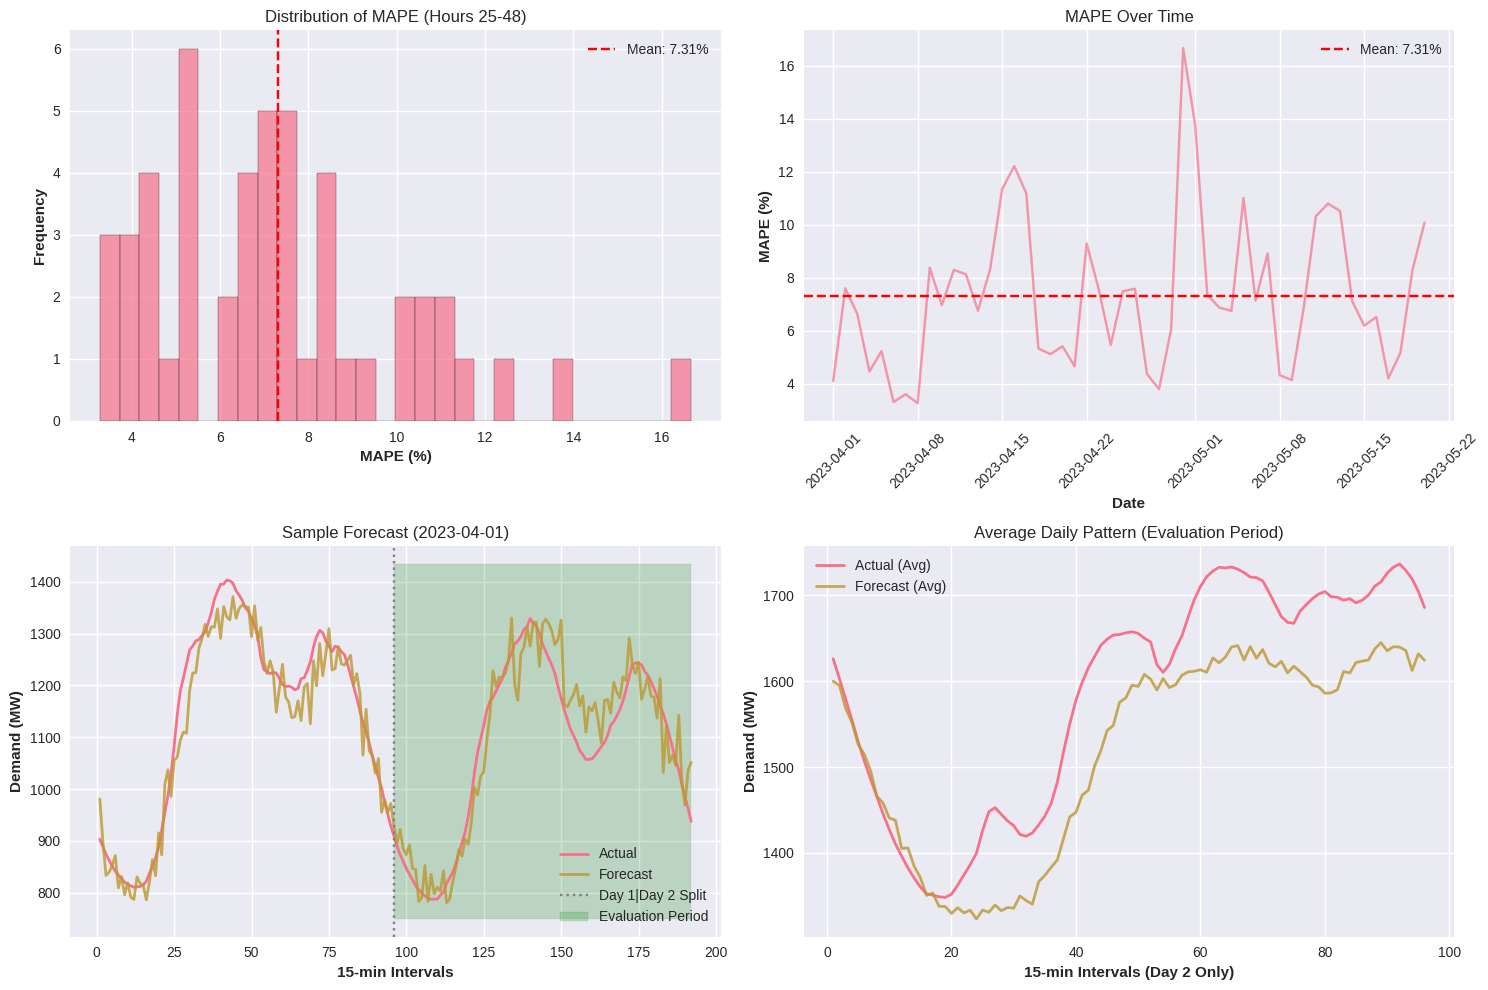


=== FINAL RESULTS SUMMARY ===
         Metric  Value
  Mean MAPE (%)  7.306
Median MAPE (%)  6.941
   Std MAPE (%)  2.826
  Mean MAE (MW) 117.77

Evaluation period: 2023-04-01 to 2023-05-20
Number of forecast days: 50
Forecast horizon: 48 hours (192 intervals)
Evaluation window: Hours 25-48 (96 intervals)


In [ ]:
# Plot MAPE distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MAPE histogram
axes[0, 0].hist(mapes, bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.mean(mapes), color='red', linestyle='--', label=f'Mean: {np.mean(mapes):.2f}%')
axes[0, 0].set_xlabel('MAPE (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of MAPE (Hours 25-48)')
axes[0, 0].legend()

# MAPE over time
axes[0, 1].plot(forecast_dates[:len(mapes)], mapes, alpha=0.7)
axes[0, 1].axhline(np.mean(mapes), color='red', linestyle='--', label=f'Mean: {np.mean(mapes):.2f}%')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].set_title('MAPE Over Time')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Sample forecast vs actual (first few days)
sample_idx = 0  # First forecast
hours = np.arange(1, 193)  # 48 hours * 4 intervals
axes[1, 0].plot(hours, actuals[sample_idx], label='Actual', linewidth=2)
axes[1, 0].plot(hours, forecasts[sample_idx], label='Forecast', linewidth=2, alpha=0.8)
axes[1, 0].axvline(96, color='gray', linestyle=':', label='Day 1|Day 2 Split')
axes[1, 0].fill_between([96, 192], axes[1, 0].get_ylim()[0], axes[1, 0].get_ylim()[1],
                       alpha=0.2, color='green', label='Evaluation Period')
axes[1, 0].set_xlabel('15-min Intervals')
axes[1, 0].set_ylabel('Demand (MW)')
axes[1, 0].set_title(f'Sample Forecast ({forecast_dates[sample_idx].strftime("%Y-%m-%d")})')
axes[1, 0].legend()

# Average daily pattern
avg_actual = np.mean(actuals_eval, axis=0)  # Average across all days (hours 25-48)
avg_forecast = np.mean(forecasts_eval, axis=0)
day2_hours = np.arange(1, 97)  # 24 hours * 4 intervals

axes[1, 1].plot(day2_hours, avg_actual, label='Actual (Avg)', linewidth=2)
axes[1, 1].plot(day2_hours, avg_forecast, label='Forecast (Avg)', linewidth=2, alpha=0.8)
axes[1, 1].set_xlabel('15-min Intervals (Day 2 Only)')
axes[1, 1].set_ylabel('Demand (MW)')
axes[1, 1].set_title('Average Daily Pattern (Evaluation Period)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary table
summary_df = pd.DataFrame({
    'Metric': ['Mean MAPE (%)', 'Median MAPE (%)', 'Std MAPE (%)', 'Mean MAE (MW)'],
    'Value': [f'{np.mean(mapes):.3f}', f'{np.median(mapes):.3f}',
              f'{np.std(mapes):.3f}', f'{mae_day2:.2f}']
})

print("\n=== FINAL RESULTS SUMMARY ===")
print(summary_df.to_string(index=False))
print(f"\nEvaluation period: {forecast_dates[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}")
print(f"Number of forecast days: {len(mapes)}")
print(f"Forecast horizon: 48 hours (192 intervals)")
print(f"Evaluation window: Hours 25-48 (96 intervals)")

## 8. Model Analysis and Feature Importance

=== LIGHTGBM FEATURE IMPORTANCE ===


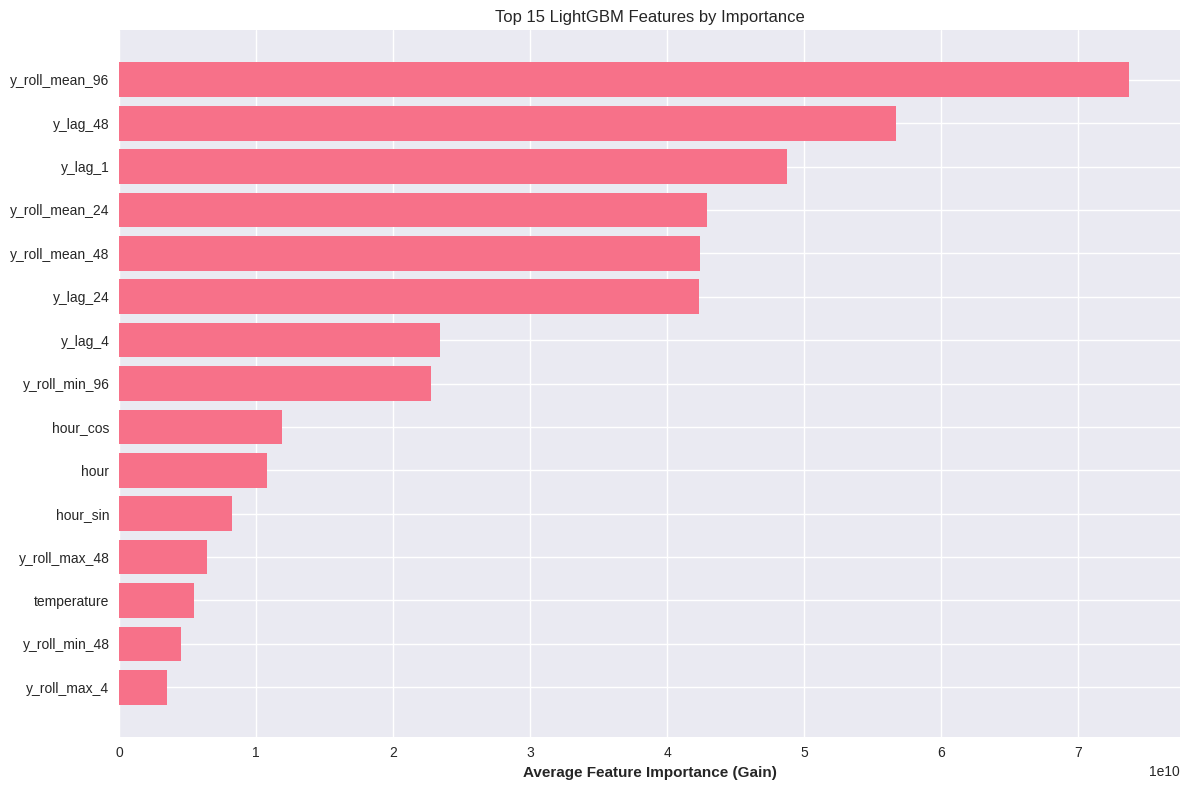

Top 10 Most Important Features:
 1. y_roll_mean_96                 73726535499.3
 2. y_lag_48                       56691357504.2
 3. y_lag_1                        48706731187.6
 4. y_roll_mean_24                 42887789641.5
 5. y_roll_mean_48                 42385104337.0
 6. y_lag_24                       42336753863.0
 7. y_lag_4                        23412008653.7
 8. y_roll_min_96                  22765660810.6
 9. hour_cos                       11847574792.9
10. hour                           10765818060.6


In [ ]:
# Get feature importance from LightGBM models
print("=== LIGHTGBM FEATURE IMPORTANCE ===")

# Average feature importance across all horizon models
feature_importance = {}
for horizon, model in lgb_model.models.items():
    importance = model.feature_importance(importance_type='gain')
    feature_names = lgb_model.feature_cols

    for i, feat in enumerate(feature_names):
        if feat not in feature_importance:
            feature_importance[feat] = []
        feature_importance[feat].append(importance[i])

# Calculate average importance
avg_importance = {feat: np.mean(scores) for feat, scores in feature_importance.items()}
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

# Plot top 15 features
top_features = sorted_features[:15]
features, scores = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.xlabel('Average Feature Importance (Gain)')
plt.title('Top 15 LightGBM Features by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Most Important Features:")
for i, (feat, score) in enumerate(top_features[:10]):
    print(f"{i+1:2d}. {feat:<30} {score:8.1f}")

In [ ]:
#Allowed the TFT to complete with one epoch, last stopped at epoch 2: hene TFT model may not have been genrated --> only light BGM?
#